# House Prices competition on Kaggle
- https://www.kaggle.com/c/house-prices-advanced-regression-techniques

To do:
- Fill NAs (somehow) in Garage-related vars

In [1]:
from IPython.display import display

In [2]:
import pandas
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy

In [3]:
import xgboost

/nix/store/11gkg09dzkvamnfiygipz78m2gjvxrz6-python3-3.5.4-env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
import sklearn
import sklearn.ensemble
import sklearn.feature_extraction
import sklearn.linear_model
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.svm

## Loading & Basic Conversion

In [5]:
train_raw = pandas.read_csv("train.csv")
test_raw  = pandas.read_csv("test.csv")

# Any columns of type 'object' should be categories.
# Also, per data_description.txt, MSSubClass is categorical, not numerical. (?)
category_cols = [n for n,t in train_raw.dtypes.iteritems() if t == object] + ["MSSubClass"]
for c in category_cols:
    train_raw[c] = train_raw[c].astype("category")
    test_raw[c] = test_raw[c].astype("category")

# Since error is based on RMSE of logarithm of prices:
train_raw = train_raw.assign(LogSalePrice = numpy.log(train_raw.SalePrice))
# Use this with 'cross_val_score' and such:
rmse = sklearn.metrics.make_scorer(
    lambda a,b: sklearn.metrics.mean_squared_error(a,b)**0.5)

### Scratch & exploration (all non-essential code):

In [6]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null category
MSZoning         1460 non-null category
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null category
Alley            91 non-null category
LotShape         1460 non-null category
LandContour      1460 non-null category
Utilities        1460 non-null category
LotConfig        1460 non-null category
LandSlope        1460 non-null category
Neighborhood     1460 non-null category
Condition1       1460 non-null category
Condition2       1460 non-null category
BldgType         1460 non-null category
HouseStyle       1460 non-null category
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null category
RoofMatl         1460 non-null cat

In [7]:
train_raw.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429216
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000,11.870600
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2007,WD,Normal,307000,12.634603
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,Shed,350,11,2009,WD,Normal,200000,12.206073
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900,11.774520
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,1,2008,WD,Normal,118000,11.678440


In [8]:
# See which columns contain nulls:
def summarize_nulls(df):
    null_count = df.isnull().sum()
    data = []
    for idx,count in null_count[null_count > 0].iteritems():
        percent_null = 100.0 * count / df.shape[0]
        data.append((idx, df.loc[:,idx].dtype, count, percent_null))
    d = pandas.DataFrame.\
        from_records(data, columns=("Feature", "Type", "NAs", "% NAs")).\
        sort_values(by="NAs", ascending=False).\
        reset_index(drop=True)
    return(d)
display(summarize_nulls(train_raw))

,Feature,Type,NAs,% NAs
0,PoolQC,category,1453,99.520548
1,MiscFeature,category,1406,96.301370
2,Alley,category,1369,93.767123
3,Fence,category,1179,80.753425
4,FireplaceQu,category,690,47.260274
5,LotFrontage,float64,259,17.739726
6,GarageType,category,81,5.547945
7,GarageYrBlt,float64,81,5.547945
8,GarageFinish,category,81,5.547945
9,GarageQual,category,81,5.547945


Notes:
- Only 7 samples have a valid `PoolQC`.
- 5 of the 7 garage-related features are present above, and all have 81 NAs. When reading the data dictionary, also note that NA actually just means "no garage" in most cases.
- The same applies to `FireplaceQu` (NA = no fireplace), `PoolQC`, `Fence`, `MiscFeature` (sort of), `Alley`, `BsmtQual`, `BsmtGotd`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `HeatingQC`
- `CentralAir` is just binary

Looking at `data-description.txt`:
- `Fence` is likely okay to treat as numerical (given the correct order).
- `PoolQC` probably is too (especially considering its sparsity)
- Likewise, `LotShape`, `KitchenQual`, `Functional`, `FireplaceQu`, `GarageFinish`, `GarageQual`, `GarageCond`, `PavedDrive`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `HeatingQC`
- `Condition1` and `Condition2` can express the same thing; likewise, `Exterior1st` and `Exterior2nd`
- `HouseStyle` is perhaps sorts of ordinal?
- `BsmtFinType1` & `BsmtFinType2`, unsure. It could be split into several vars perhaps.

#### Summarize columns (numerical, then categorical):

In [9]:
stride = 13
for t in (numpy.number, "category"):
    i = 0
    while (i + stride) < train_raw.shape[1]:
        display(train_raw.iloc[:,i:(i+stride)].describe(include=[t]))
        i += stride

,Id,LotFrontage,LotArea
count,1460.000000,1201.000000,1460.000000
mean,730.500000,70.049958,10516.828082
std,421.610009,24.284752,9981.264932
min,1.000000,21.000000,1300.000000
25%,365.750000,59.000000,7553.500000
50%,730.500000,69.000000,9478.500000
75%,1095.250000,80.000000,11601.500000
max,1460.000000,313.000000,215245.000000


,OverallQual,OverallCond,YearBuilt,YearRemodAdd
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,5.575342,1971.267808,1984.865753
std,1.382997,1.112799,30.202904,20.645407
min,1.000000,1.000000,1872.000000,1950.000000
25%,5.000000,5.000000,1954.000000,1967.000000
50%,6.000000,5.000000,1973.000000,1994.000000
75%,7.000000,6.000000,2000.000000,2004.000000
max,10.000000,9.000000,2010.000000,2010.000000


,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
count,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,103.685262,443.639726,46.549315,567.240411,1057.429452
std,181.066207,456.098091,161.319273,441.866955,438.705324
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,223.000000,795.750000
50%,0.000000,383.500000,0.000000,477.500000,991.500000
75%,166.000000,712.250000,0.000000,808.000000,1298.250000
max,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000


,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438
std,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778
min,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000
75%,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000
max,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000


,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea
count,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000
mean,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137
std,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841
min,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000
25%,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000
50%,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000
75%,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000
max,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000


,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood
count,1460,1460,1460,91,1460,1460,1460,1460,1460,1460
unique,15,5,2,2,4,4,2,5,3,25
top,20,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes
freq,536,1151,1454,50,925,1311,1459,1052,1382,225


,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType
count,1460,1460,1460,1460,1460,1460,1460,1460,1452
unique,9,8,5,8,6,8,15,16,4
top,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None
freq,1260,1445,1220,726,1141,1434,515,504,864


,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
count,1460,1460,1460,1423,1423,1422,1423,1422
unique,4,5,6,4,4,4,6,6
top,TA,TA,PConc,TA,TA,No,Unf,Unf
freq,906,1282,647,649,1311,953,430,1256


,Heating,HeatingQC,CentralAir,Electrical
count,1460,1460,1460,1459
unique,6,5,2,5
top,GasA,Ex,Y,SBrkr
freq,1428,741,1365,1334


,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond
count,1460,1460,770,1379,1379,1379,1379
unique,4,7,5,6,3,5,5
top,TA,Typ,Gd,Attchd,Unf,TA,TA
freq,735,1360,380,870,605,1311,1326


,PavedDrive,PoolQC,Fence,MiscFeature
count,1460,7,281,54
unique,3,3,4,4
top,Y,Gd,MnPrv,Shed
freq,1340,3,157,49


In [10]:
# See distributions in categorical columns:
for (name,type_) in train_raw.dtypes.iteritems():
    if type_.name == "category":
        print(train_raw[[name]].groupby(name).size())
        print()

MSSubClass
20     536
30      69
40       4
45      12
50     144
60     299
70      60
75      16
80      58
85      20
90      52
120     87
160     63
180     10
190     30
dtype: int64

MSZoning
C (all)      10
FV           65
RH           16
RL         1151
RM          218
dtype: int64

Street
Grvl       6
Pave    1454
dtype: int64

Alley
Grvl    50
Pave    41
dtype: int64

LotShape
IR1    484
IR2     41
IR3     10
Reg    925
dtype: int64

LandContour
Bnk      63
HLS      50
Low      36
Lvl    1311
dtype: int64

Utilities
AllPub    1459
NoSeWa       1
dtype: int64

LotConfig
Corner      263
CulDSac      94
FR2          47
FR3           4
Inside     1052
dtype: int64

LandSlope
Gtl    1382
Mod      65
Sev      13
dtype: int64

Neighborhood
Blmngtn     17
Blueste      2
BrDale      16
BrkSide     58
ClearCr     28
CollgCr    150
Crawfor     51
Edwards    100
Gilbert     79
IDOTRR      37
MeadowV     17
Mitchel     49
NAmes      225
NPkVill      9
NWAmes      73
NoRidge     41
NridgH

## Conversion & Preprocessing

In [11]:
def preprocess(df):
    # CentralAir is just binary.
    # Street has two choices (gravel/paved) - so make binary StreetGravel.
    # Helper function to turn list into dictionary mapping element -> index:
    mkdict = lambda *l: dict([(el,i) for i,el in enumerate(l)])
    # Various columns are ordinal. We define (and reuse) some mappings below.
    lotshape = mkdict("Reg", "IR1", "IR2", "IR3")
    landcontour = mkdict("Lvl", "Bnk", "HLS", "Low") # not sure
    utils = mkdict("AllPub", "NoSewr", "NoSeWa", "ELO")
    slope = mkdict("Gtl", "Mod", "Sev")
    street = mkdict("Grvl", "Pave")
    alley = mkdict("NA", "Grvl", "Pave")
    qual = {"NA": -3, "Po": -2, "Fa": -1, "TA": 0, "Gd": 1, "Ex": 2}
    exp = mkdict("NA", "No", "Mn", "Av", "Gd")
    fintype = mkdict("NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ")
    elec = mkdict("Mix", "FuseP", "FuseF", "FuseA", "SBrkr")
    funct = mkdict("Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ")
    pave = mkdict("N", "P", "Y")
    fence = mkdict("NA", "MnWw", "GdWo", "MnPrv", "GdPrv")
    gf = mkdict("NA", "Unf", "RFn", "Fin")
    # Return column 'col' from df, converted according to dictionary 'dict'.
    # If 'col' contains NAs, 'null' must be set True.
    def df_get(col, dict_, null=False):
        if null:
            # To turn NA to "NA", it must be in the category levels:
            d = df[col].cat.add_categories(["NA"]).fillna("NA")
        else:
            d = df[col]
        return d.apply(lambda x: dict_[x]).astype(float)
    # Finally, start converting:
    df2 = df.assign(CentralAir = df.CentralAir == 'Y').\
        assign(Street       = df_get("Street",       street),
               Alley        = df_get("Alley",        alley, True),
               LandContour  = df_get("LandContour",  landcontour),
               LotShape     = df_get("LotShape",     lotshape),
               Utilities    = df_get("Utilities",    utils),
               LandSlope    = df_get("LandSlope",    slope),
               ExterQual    = df_get("ExterQual",    qual),
               ExterCond    = df_get("ExterCond",    qual),
               BsmtQual     = df_get("BsmtQual",     qual, True),
               BsmtCond     = df_get("BsmtCond",     qual, True),
               BsmtExposure = df_get("BsmtExposure", exp, True),
               BsmtFinType1 = df_get("BsmtFinType1", fintype, True),
               BsmtFinType2 = df_get("BsmtFinType2", fintype, True),
               HeatingQC    = df_get("HeatingQC",    qual),
               Electrical   = df_get("Electrical",   elec),
               KitchenQual  = df_get("KitchenQual",  qual),
               Functional   = df_get("Functional",   funct),
               FireplaceQu  = df_get("FireplaceQu",  qual, True),
               GarageFinish = df_get("GarageFinish", gf, True),
               GarageQual   = df_get("GarageQual",   qual, True),
               GarageCond   = df_get("GarageCond",   qual, True),
               PavedDrive   = df_get("PavedDrive",   pave),
               PoolQC       = df_get("PoolQC",       qual, True),
               Fence        = df_get("Fence",        fence, True),
              )
    return df2

train = preprocess(train_raw)
test = preprocess(test_raw)

### Examining results again after this:

In [12]:
display(summarize_nulls(pandas.concat((train, test))))

,Feature,Type,NAs,% NAs
0,MiscFeature,object,2814,96.402878
1,SalePrice,float64,1459,49.982871
2,LogSalePrice,float64,1459,49.982871
3,LotFrontage,float64,486,16.649538
4,GarageYrBlt,float64,159,5.447071
5,GarageType,category,157,5.378554
6,MasVnrType,category,24,0.822199
7,MasVnrArea,float64,23,0.787941
8,MSZoning,category,4,0.137033
9,Utilities,float64,2,0.068517


In [13]:
display(train[train.MasVnrType.isnull()][["MasVnrType", "MasVnrArea"]])
display(train[["MasVnrType"]].groupby("MasVnrType").size())

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


MasVnrType
BrkCmn      15
BrkFace    445
None       864
Stone      128
dtype: int64

In [14]:
train[train.GarageType.isnull()][["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual"]].describe()

,GarageYrBlt,GarageFinish,GarageQual
count,0.0,81.0,81.0
mean,NaN,0.0,-3.0
std,NaN,0.0,0.0
min,NaN,0.0,-3.0
25%,NaN,0.0,-3.0
50%,NaN,0.0,-3.0
75%,NaN,0.0,-3.0
max,NaN,0.0,-3.0


In [15]:
display(train[["Electrical"]].groupby("Electrical").size())

Electrical
0.0       1
1.0       3
2.0      27
3.0      94
4.0    1334
dtype: int64

In [16]:
# Examine street-related features with the NAs in LotFrontage:
train[["LotFrontage", "LotArea", "LotShape", "Street", "Condition1", "Condition2"]][train.LotFrontage.isnull()].describe(include='all')

,LotFrontage,LotArea,LotShape,Street,Condition1,Condition2
count,0.0,259.000000,259.000000,259.000000,259,259
unique,NaN,NaN,NaN,NaN,9,3
top,NaN,NaN,NaN,NaN,Norm,Norm
freq,NaN,NaN,NaN,NaN,223,257
mean,NaN,13137.370656,0.795367,0.996139,NaN,NaN
std,NaN,16215.264451,0.591131,0.062137,NaN,NaN
min,NaN,1974.000000,0.000000,0.000000,NaN,NaN
25%,NaN,8065.500000,0.000000,1.000000,NaN,NaN
50%,NaN,10624.000000,1.000000,1.000000,NaN,NaN
75%,NaN,13018.500000,1.000000,1.000000,NaN,NaN


Notes on the remaining NAs:
- `MiscFeature`: NA means the lack of any feature. Encoding should handle this.
- `GarageType` and `GarageYrBlt` are NA for the lack of a garage.
- The single NA in `Electrical` can probably be set to `SBrkr`
- `MasVnrType` and `MasVnrArea` are NA together, and perhaps can be set to `None` (the mode) given how few examples this applies to.
- `LotFrontage`: No apparent order in this. Replacing with 0 might be okay.

In [17]:
def fill_missing(df):
    miscfeatures = pandas.get_dummies(df.MiscFeature, prefix="MiscFeature")
    df2 = pandas.concat([df, miscfeatures], axis=1).\
        assign(Electrical = df.Electrical.fillna("SBrkr"),
               MasVnrType = df.MasVnrType.fillna("None"),
               MasVnrArea = df.MasVnrArea.fillna(0.0),
               LotFrontage = df.LotFrontage.fillna(0.0),
               BsmtFullBath = df.BsmtFullBath.fillna(0),
               BsmtHalfBath = df.BsmtFullBath.fillna(0),
               TotalBsmtSF = df.TotalBsmtSF.fillna(0),
               BsmtFinSF1 = df.BsmtFinSF1.fillna(0),
               BsmtFinSF2 = df.BsmtFinSF2.fillna(0),
               GarageArea = df.GarageArea.fillna(0),
               BsmtUnfSF = df.BsmtUnfSF.fillna(0),
               GarageCars = df.GarageCars.fillna(0),
               Functional = df.Functional.fillna(0),
               Utilities = df.Utilities.fillna(0),
               KitchenQual = df.KitchenQual.fillna(0),
              ).\
        drop("MiscFeature", axis=1)
    # GarageType, GarageYrBit
    return df2

train = fill_missing(train)
test = fill_missing(test).assign(MiscFeature_TenC = 0)

In [18]:
display(summarize_nulls(pandas.concat((train, test))))

,Feature,Type,NAs,% NAs
0,LogSalePrice,float64,1459,49.982871
1,SalePrice,float64,1459,49.982871
2,GarageYrBlt,float64,159,5.447071
3,GarageType,category,157,5.378554
4,MSZoning,category,4,0.137033
5,Exterior1st,object,1,0.034258
6,Exterior2nd,object,1,0.034258
7,SaleType,category,1,0.034258


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 85 columns):
Id                  1460 non-null int64
MSSubClass          1460 non-null category
MSZoning            1460 non-null category
LotFrontage         1460 non-null float64
LotArea             1460 non-null int64
Street              1460 non-null float64
Alley               1460 non-null float64
LotShape            1460 non-null float64
LandContour         1460 non-null float64
Utilities           1460 non-null float64
LotConfig           1460 non-null category
LandSlope           1460 non-null float64
Neighborhood        1460 non-null category
Condition1          1460 non-null category
Condition2          1460 non-null category
BldgType            1460 non-null category
HouseStyle          1460 non-null category
OverallQual         1460 non-null int64
OverallCond         1460 non-null int64
YearBuilt           1460 non-null int64
YearRemodAdd        1460 non-null int64
RoofStyle      

## Various category columns still need to be one-hot encoded:

In [20]:
def preprocess2(df):
    onehot_vals = {}
    columns = df.select_dtypes(('category',)).columns
    for column in columns:
        feature = df[column]
        feature_onehot = pandas.get_dummies(feature, column)
        df = df.join(feature_onehot)
    return df

In [21]:
train2 = preprocess2(train)
test2 = preprocess2(test)

cols_numerical = list(train2.select_dtypes((numpy.number,)).columns)
for c in ("GarageYrBlt", "Id", "LogSalePrice", "SalePrice"):
    cols_numerical.remove(c)

# Only missing categories should be NAs at this point:
missing = {col: 0 for col in cols_numerical if col not in test2.columns}
test2 = test2.assign(**missing)

`cols_numerical` then has a list of all numerical columns (of which we now include the encodings of the categorical ones):

In [22]:
cols_numerical = list(train2.select_dtypes((numpy.number,)).columns)
for c in ("GarageYrBlt", "Id", "LogSalePrice", "SalePrice"):
    cols_numerical.remove(c)
len(cols_numerical)

223

## Standardize data

`train_X_all` is all these columns for the training data:

In [23]:
train_X_all = train2[cols_numerical].copy()
train_Y = train2["LogSalePrice"]
test_X = test2[cols_numerical].copy()

ss = sklearn.preprocessing.StandardScaler().fit(train_X_all)
train_X_all.iloc[:,:] = ss.transform(train_X_all)
test_X.iloc[:,:] = ss.transform(test_X)

## RandomForestRegressor to find feature importances
- The below passes `train_X_all` to RandomForestRegressor mainly to get feature importances as a side effect via `feature_importances_`.
- The `feature_importances_` decay very quickly, so the logarithm was taken (and brought to a minimum of zero) in order to actually plot:

In [24]:
rf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=100, n_jobs=-1, oob_score=True)
rf = rf.fit(train_X_all, train_Y)

In [25]:
features = pandas.DataFrame(
    {"Feature": list(train_X_all.columns),
     "Importance": rf.feature_importances_}).\
    sort_values("Importance", ascending=False).\
    reset_index(drop=True)
# Show top 100:
features = features.iloc[:100, :]
features = features.assign(LogImportance = numpy.log(features.Importance))
features = features.\
    assign(LogImportance = features.LogImportance - min(features.LogImportance))
features.loc[:,("Feature", "Importance")].style.format({"Importance": "{:.6f}"})

,Feature,Importance
0,OverallQual,0.552699
1,GrLivArea,0.111079
2,TotalBsmtSF,0.047135
3,GarageCars,0.046091
4,1stFlrSF,0.023024
5,BsmtFinSF1,0.018936
6,GarageArea,0.018666
7,YearBuilt,0.017831
8,LotArea,0.013061
9,OverallCond,0.012543


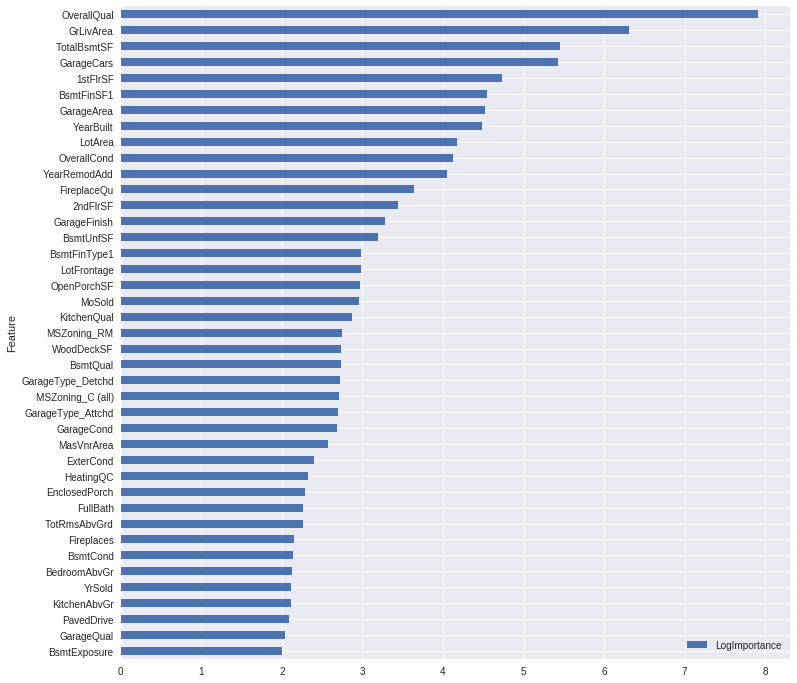

In [26]:
%matplotlib inline
fig = features.iloc[40::-1,:].plot.barh(x="Feature", y="LogImportance", figsize=(12,12))

`cols_reduced` is taken from the sorted list of most-important columns above:

In [27]:
cols_reduced = list(features.Feature)
train_X_top = train_X_all[cols_reduced]

## Try some models...

In [28]:
def plot_validation(train_scores, test_scores, param_range, linear=False):
    # Code adapted from:
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
    train_scores_mean = numpy.mean(train_scores, axis=1)
    train_scores_std = numpy.std(train_scores, axis=1)
    test_scores_mean = numpy.mean(test_scores, axis=1)
    test_scores_std = numpy.std(test_scores, axis=1)
    plt.ylabel("Score")
    #plt.ylim(0.0, 1.1)
    lw = 2
    if linear:
        plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    else:
        plt.semilogx(param_range, train_scores_mean, label="Training score",
                     color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    if linear:
        plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    else:
        plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                     color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

Min error 0.1368646362156948 at alpha=316.22776601683796


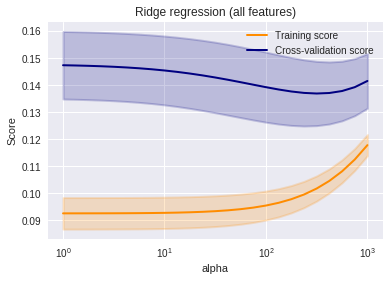

In [29]:
# First, Ridge regression on all features:
rr = sklearn.linear_model.Ridge()
alpha_range = numpy.logspace(0, 3, 25)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    rr,
    train_X_all,
    train_Y,
    "alpha",
    alpha_range,
    scoring = rmse)
valid_means = valid_scores.mean(axis=1)
idx = numpy.argmin(valid_means)
print("Min error {0} at alpha={1}".format(valid_means[idx], alpha_range[idx]))

plt.title("Ridge regression (all features)")
plt.xlabel("alpha")
plot_validation(train_scores, valid_scores, alpha_range)

Min error 0.14080244422580487 at alpha=237.13737056616552


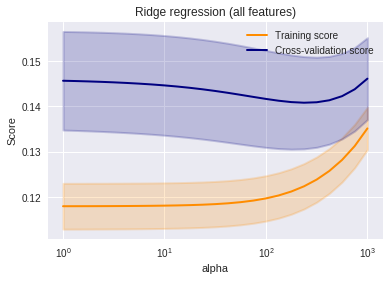

In [30]:
# and reduced features:
rr = sklearn.linear_model.Ridge()
alpha_range = numpy.logspace(0, 3, 25)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    rr,
    train_X_top,
    train_Y,
    "alpha",
    alpha_range,
    scoring = rmse)
valid_means = valid_scores.mean(axis=1)
idx = numpy.argmin(valid_means)
print("Min error {0} at alpha={1}".format(valid_means[idx], alpha_range[idx]))

plt.title("Ridge regression (all features)")
plt.xlabel("alpha")
plot_validation(train_scores, valid_scores, alpha_range)

Min error 0.1352560959701386 at alpha=0.004641588833612777


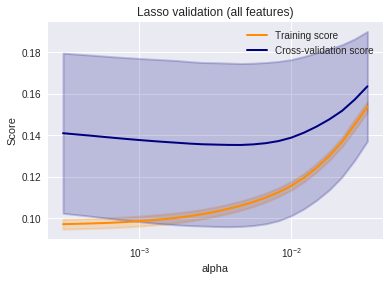

In [31]:
# And Lasso regression on all features:
lr = sklearn.linear_model.Lasso()
alpha_range = numpy.logspace(-3.5, -1.5, 25)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    lr,
    train_X_all,
    train_Y,
    "alpha",
    alpha_range,
    scoring = rmse,
    cv=10)
valid_means = valid_scores.mean(axis=1)
idx = numpy.argmin(valid_means)
print("Min error {0} at alpha={1}".format(valid_means[idx], alpha_range[idx]))

plt.title("Lasso validation (all features)")
plt.xlabel("alpha")
plot_validation(train_scores, valid_scores, alpha_range)

Min error 0.14143798418695677 at alpha=0.0031622776601683794


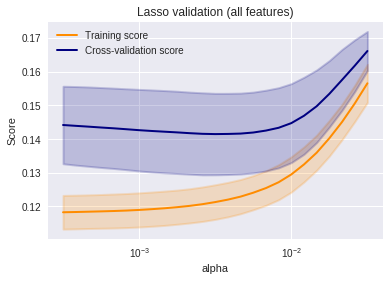

In [32]:
# And on reduced features:
# (Trouble converging here for some reason)
lr = sklearn.linear_model.Lasso()
alpha_range = numpy.logspace(-3.5, -1.5, 25)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    lr,
    train_X_top,
    train_Y,
    "alpha",
    alpha_range,
    scoring = rmse)
valid_means = valid_scores.mean(axis=1)
idx = numpy.argmin(valid_means)
print("Min error {0} at alpha={1}".format(valid_means[idx], alpha_range[idx]))

plt.title("Lasso validation (all features)")
plt.xlabel("alpha")
plot_validation(train_scores, valid_scores, alpha_range)

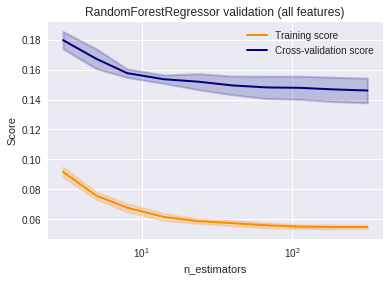

In [33]:
rf = sklearn.ensemble.RandomForestRegressor(
    n_jobs=-1, random_state=12348)
# TODO: Can I use out-of-bag score here rather than cross-validation?
est_range = numpy.logspace(0.5, 2.5, 10).astype(int)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    rf,
    train_X_all,
    train_Y,
    "n_estimators",
    est_range,
    scoring = rmse)

plt.title("RandomForestRegressor validation (all features)")
plt.xlabel("n_estimators")
plot_validation(train_scores, valid_scores, est_range)

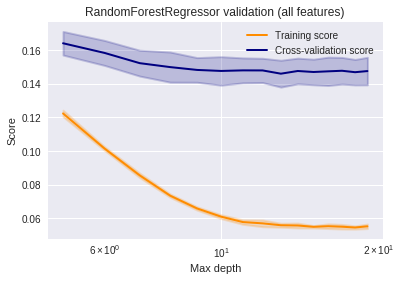

In [34]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=100, n_jobs=-1)
# TODO: Can I use out-of-bag score here rather than cross-validation?
depth_range = numpy.arange(5, 20).astype(int)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    rf,
    train_X_all,
    train_Y,
    "max_depth",
    depth_range,
    scoring = rmse)

plt.title("RandomForestRegressor validation (all features)")
plt.xlabel("Max depth")
plot_validation(train_scores, valid_scores, depth_range)

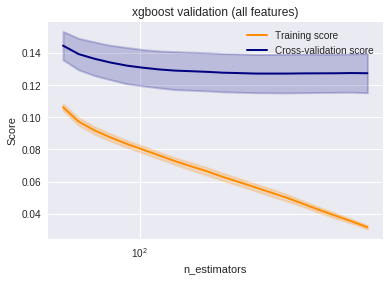

In [35]:
xgb = xgboost.sklearn.XGBRegressor(nthread=-1, seed=12345)
est_range = numpy.logspace(1.75, 2.75, 20).astype(int)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    xgb,
    train_X_all,
    train_Y,
    "n_estimators",
    est_range,
    scoring = rmse)

plt.title("xgboost validation (all features)")
plt.xlabel("n_estimators")
plot_validation(train_scores, valid_scores, est_range)

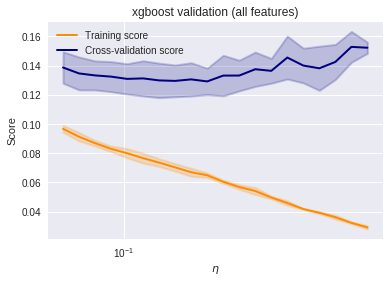

In [36]:
xgb = xgboost.sklearn.XGBRegressor(nthread=-1, seed=12345, n_estimators=100)
eta_range = numpy.logspace(-1.2, -0.2, 20)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    xgb,
    train_X_all,
    train_Y,
    "learning_rate",
    eta_range,
    scoring = rmse)

plt.title("xgboost validation (all features)")
plt.xlabel("$\eta$")
plot_validation(train_scores, valid_scores, eta_range)

Min error 0.12421294863572963 at depth=2


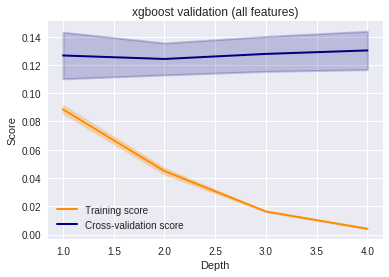

In [37]:
xgb = xgboost.sklearn.XGBRegressor(nthread=-1, seed=12345, learning_rate=0.1, n_estimators=1000)
depth_range = numpy.arange(1, 5)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    xgb,
    train_X_all,
    train_Y,
    "max_depth",
    depth_range,
    scoring = rmse)
valid_means = valid_scores.mean(axis=1)
idx = numpy.argmin(valid_means)
print("Min error {0} at depth={1}".format(valid_means[idx], depth_range[idx]))

plt.title("xgboost validation (all features)")
plt.xlabel("Depth")
plot_validation(train_scores, valid_scores, depth_range, linear=True)

## Try out a zoo of models...

In [38]:
models = {
    "Lasso": sklearn.linear_model.Lasso(alpha=0.0046),
    "Ridge": rr,
    "xgboost": xgboost.sklearn.XGBRegressor(nthread=-1, seed=12345, n_estimators=1000, learning_rate=0.1),
    "xgboost, depth 2, 1000 iters": xgboost.sklearn.XGBRegressor(nthread=-1, seed=12345, n_estimators=1000, max_depth=2, learning_rate=0.1),
    "xgboost, depth 2, 2000 iters": xgboost.sklearn.XGBRegressor(nthread=-1, seed=12345, n_estimators=2000, max_depth=2, learning_rate=0.1),
    "RF": sklearn.ensemble.RandomForestRegressor(n_estimators=100, n_jobs=-1)
}

### All columns:

In [39]:
data = []
for name in models:
    scores = sklearn.model_selection.cross_val_score(
        models[name],
        train_X_all,
        train_Y,
        scoring=rmse,
        cv=10)
    data.append((name, scores.mean(), scores.std() * 2))
data = pandas.DataFrame.from_records(
    data, columns=("Model", "Mean Accuracy", "Std. Dev."))
data.reset_index(drop=True).sort_values("Model", inplace=True)
data

,Model,Mean Accuracy,Std. Dev.
0,"xgboost, depth 2, 1000 iters",0.120883,0.043889
1,Ridge,0.145431,0.075239
2,RF,0.139855,0.036342
3,"xgboost, depth 2, 2000 iters",0.122059,0.042574
4,Lasso,0.135252,0.078592
5,xgboost,0.122654,0.039377


### Reduced columns:

In [40]:
data = []
for name in models:
    scores = sklearn.model_selection.cross_val_score(
        models[name],
        train_X_top,
        train_Y,
        scoring=rmse)
    data.append((name, scores.mean(), scores.std() * 2))
data = pandas.DataFrame.from_records(
    data, columns=("Model", "Mean Accuracy", "Std. Dev."))
data.reset_index(drop=True).sort_values("Model", inplace=True)
data

,Model,Mean Accuracy,Std. Dev.
0,"xgboost, depth 2, 1000 iters",0.122560,0.019030
1,Ridge,0.145638,0.021698
2,RF,0.145968,0.014803
3,"xgboost, depth 2, 2000 iters",0.123616,0.018693
4,Lasso,0.141578,0.023999
5,xgboost,0.126555,0.026049


## Generate submission!

In [41]:
# Below model is an ensemble of XGBoost and Lasso:
# (is it still an ensemble if it uses just two?)
model1 = xgboost.sklearn.XGBRegressor(nthread=-1, seed=12345, max_depth=2, n_estimators=2000, learning_rate=0.1) #sklearn.linear_model.Lasso()
model1.fit(train_X_all, train_Y)
predictions1 = model1.predict(test_X)
model2 = sklearn.linear_model.Lasso(alpha=0.0046)
model2.fit(train_X_all, train_Y)

predictions2 = model2.predict(test_X)
predictions = (predictions1 + predictions2) / 2
# This is predicting the log of the sale price, so use exponential to convert back:
submission = test[["Id"]].copy().\
    assign(SalePrice = numpy.exp(predictions))
submission.to_csv("submission.csv", index=False)